# A. Introduction
For this project, we are tasked with choosing a dataset and investigating it to arrive at conclusions about the data. I have chosen the Titanic Survivor dataset for this project. This dataset contains data about the characteristics of the passengers of the Titanic vessel, such as Gender, class, ticket fare, whether they survived or not, etc.

A cursory look at the dataset presents us with questions such as:
* Did gender play a significant role in determining whether one survived or not?
* Did class play a significant role in determining whether one survived or not?
* Did age group play a significant role in determining whether one survived or not?
* Did family size play a significant role in determining whether one survived or not?

We will try to answer these questions in our analysis below.

# B. Data Wrangling
Let us investigate the dataset to learn the formats of the data, inconsistencies in the data and if any cleanup is required.

## B.1 Loading the dataset

In [538]:
#importing required modules
import csv
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%pylab inline
sns.set_style("dark")

titanic=pd.read_csv("titanic-data.csv")
titanic.head()

Populating the interactive namespace from numpy and matplotlib


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The dataset has been loaded successfully. 
Let us look at our factors of interest for this project: Gender, Age and Pclass.

In [539]:
titanic[['Sex','Age','Pclass']].describe(include='all')

,Sex,Age,Pclass
count,891,714.000000,891.000000
unique,2,NaN,NaN
top,male,NaN,NaN
freq,577,NaN,NaN
mean,NaN,29.699118,2.308642
std,NaN,14.526497,0.836071
min,NaN,0.420000,1.000000
25%,NaN,20.125000,2.000000
50%,NaN,28.000000,3.000000
75%,NaN,38.000000,3.000000


The Age column seems to have some missing values.

In [540]:
sum(titanic['Age'].isnull())

177

177 records have missing values for Age. In order to fill in missing values, we can group the data and take the mean age of each group. 

## B.2 Missing data
Let us look at the distribution of age based on different factors.

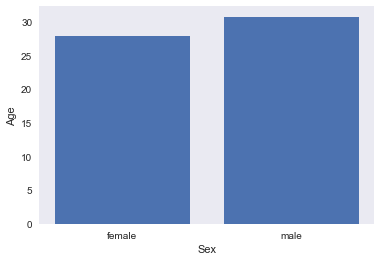

In [541]:
#This function is used to plot a bar chart of the median ages of different groups bsaed on the "groupByField"
def groupByPlot(groupByField,aggregateField):
    groupedDF=pd.DataFrame(titanic.groupby([groupByField])[aggregateField].mean()).reset_index()
    
    plt.bar(range(len(groupedDF)),groupedDF[aggregateField])
    plt.xticks(range(len(groupedDF)),groupedDF.ix[:,0])
    plt.ylabel(aggregateField)
    plt.xlabel(groupByField)

groupByPlot('Sex','Age')

There isn't much difference in the ages between the male and female groups. Let us try other factors - Pclass, Parch and SibSp.

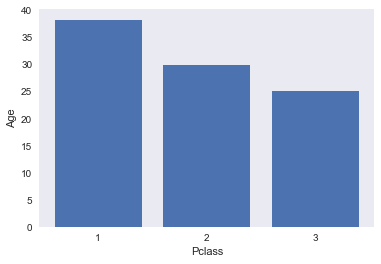

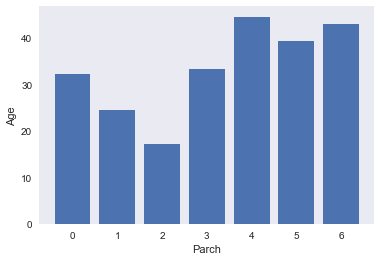

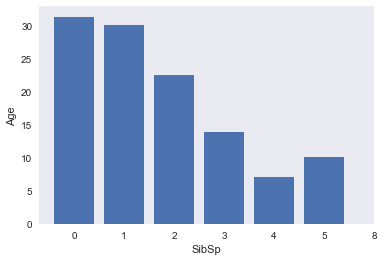

In [542]:
plt.figure(1)
groupByPlot('Pclass','Age')

plt.figure(2)
groupByPlot('Parch','Age')

plt.figure(3)
groupByPlot('SibSp','Age')

Looking at these graphs, it appears that Parch may be a good factor to determine the missing ages. SibSp could not be used as it has some groups where all records have missing values for Age column.

In [543]:
groupedDF=titanic.groupby(['Parch'])['Age'].mean()
display(groupedDF)
def fillMissingAges(record):
    if pd.isnull(record['Age']):
        record['Age']=groupedDF[record['Parch']]

    return record

titanic=titanic.apply(fillMissingAges,axis=1)
titanic.info()
display(titanic.groupby(['Parch'])['Age'].mean())

Parch
0    32.178503
1    24.422000
2    17.216912
3    33.200000
4    44.500000
5    39.200000
6    43.000000
Name: Age, dtype: float64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


Parch
0    32.178503
1    24.422000
2    17.216912
3    33.200000
4    44.500000
5    39.200000
6    43.000000
Name: Age, dtype: float64

We can see that the missing Ages have been filled up and the mean is preserved for each Parch group.

## B.3 Remove unwanted data
The only columns we need for our analysis based on the questions we raised are:
* Survived
* Pclass
* Sex
* Age
* SibSp
* Parch

We can remove the other columns from the dataframe.

In [544]:
titanic=titanic.drop(['PassengerId','Name','Ticket','Cabin','Embarked','Fare'],axis=1)

## B.4 Modifying data
### B.4.1 Age Groups
The Age column contains continuous numeric information that may be more useful if available in a categorical form. Let us investigate the Age column:

In [545]:
titanic['Age'].describe()

count    891.000000
mean      29.920509
std       13.131596
min        0.420000
25%       22.000000
50%       31.000000
75%       35.000000
max       80.000000
Name: Age, dtype: float64

The Age ranges from 0 to 80 in the dataset. I will create a new column called AgeGroup, and transform the Age data into categorical format using the cut function, with intervals of 10 years.

In [546]:
ageLabels=[str(i)+" - "+str(i+10) for i in range(0,71,10)]
titanic['AgeGroup']=pd.cut(titanic['Age'],range(0,81,10),labels=ageLabels)
titanic.groupby(['AgeGroup']).count().reset_index()

,AgeGroup,Survived,Pclass,Sex,Age,SibSp,Parch
0,0 - 10,64,64,64,64,64,64
1,10 - 20,127,127,127,127,127,127
2,20 - 30,238,238,238,238,238,238
3,30 - 40,312,312,312,312,312,312
4,40 - 50,86,86,86,86,86,86
5,50 - 60,42,42,42,42,42,42
6,60 - 70,17,17,17,17,17,17
7,70 - 80,5,5,5,5,5,5


### B.4.2 Family Size
We can create a FamilySize column to indicate the size of the family. The family size can calculated by adding the Parch and SibSp columns.

In [547]:
titanic['FamilySize'] = titanic['Parch']+titanic['SibSp']

# C. Data Exploration
Before we start, it is good to have an idea of the total number of survivors in the sample provided.

In [548]:
display(sum(titanic['Survived']))
display(sum(titanic['Survived'])*1.0/len(titanic))

342

0.38383838383838381

342 out of 891 survived, giving a survival rate of 38.38%.

Let us visualize the data using charts to develop some intuition before running statistical tests to confirm our intuitions.

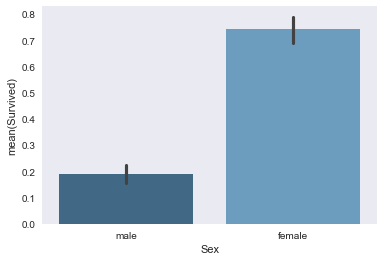

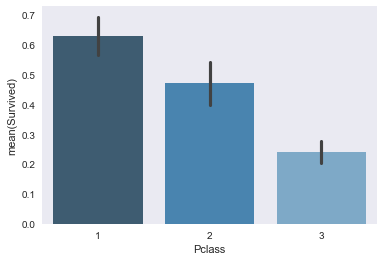

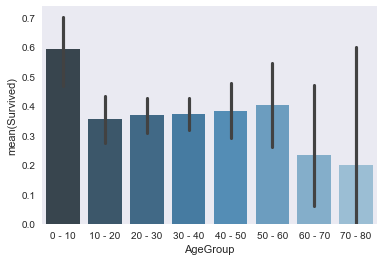

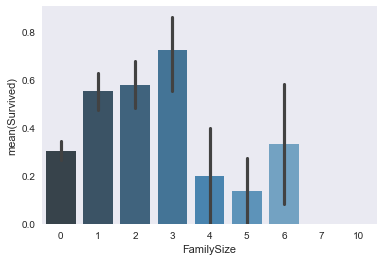

In [549]:
plt.figure(1)
sns.barplot('Sex','Survived',data=titanic,palette='Blues_d')
plt.figure(2)
sns.barplot('Pclass','Survived',data=titanic,palette='Blues_d')
plt.figure(3)
sns.barplot('AgeGroup','Survived',data=titanic,palette='Blues_d')
plt.figure(4)
sns.barplot('FamilySize','Survived',data=titanic,palette='Blues_d')

Looking at these charts, we can develop the following intuitions about the impact of various factors on probability of survival. We will conduct statistical tests to confirm these in the following sections.
* Females were given the priority over males
* First class passengers had higher preference over second class, who in turn had higher preference over third class
* Children (age 0-10) were given first preference over all the other age groups
* Families of size 3 had the highest chances of survival - this makes sense since women and children were preferred to other groups.

Let us look at some blended charts to see the effect of multiple factors on survival at the same time.

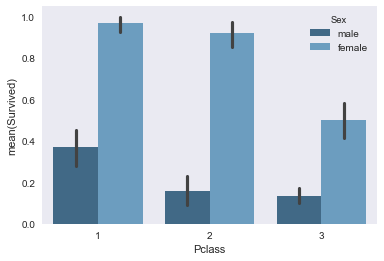

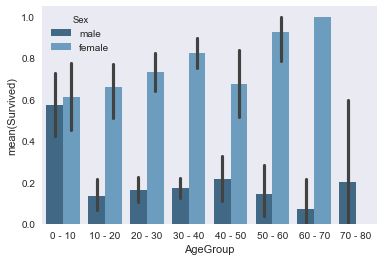

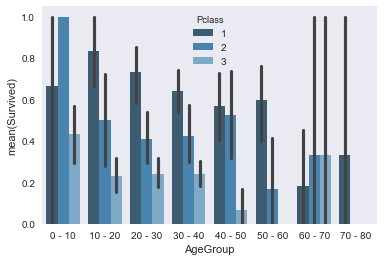

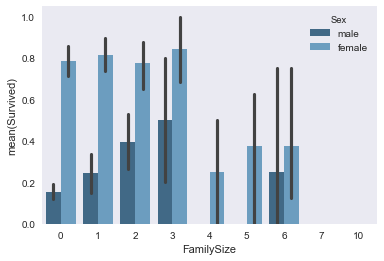

In [550]:
plt.figure(1)
sns.barplot('Pclass','Survived',hue='Sex',data=titanic,palette='Blues_d')
plt.figure(2)
sns.barplot('AgeGroup','Survived',hue='Sex',data=titanic,palette='Blues_d')
plt.figure(3)
sns.barplot('AgeGroup','Survived',hue='Pclass',data=titanic,palette='Blues_d')
plt.figure(4)
sns.barplot('FamilySize','Survived',hue='Sex',data=titanic,palette='Blues_d')

Look at these graphs, we can infer the following:
* The preference for females over males for survival seems to exist any which way we slice the data - across different classes, age groups and family sizes
* We previously saw that children within the ages 0-10 were favored over other age groups. But on looking further, females in the all age groups seem to have had higher probability of survival
* Looking at the different age groups grouped by class, it seems children from second class had a very high chance of survival (all children in age group 0-10 from second class survived)
* Finally, while we saw that a family size of 3 had the highest chances of survival, females from families of size up to 3 had higher chances of survival than the others

All these graphs assert that the "women and children first" policy was strictly enforced during the evacuation of the ship$^2$.

Let us run some statistical tests to either confirm or reject some these inferences and to answer the questions we raised initially.

## C.1 Gender
Did gender play an important role in determining whether one survived or not?

The dependent variable is 'Survived' and the independent variable is 'Sex'. The null and alternative hypotheses are given below.

* H$_0$: Probability of survival and Gender are independent

* H$_A$: Probability of survival and Gender are not independent

Since both are categorical variables, we can run a chi-squared test for this purpose$^1$.

In [551]:
#This function takes in the names of two columns form the titanic dataset on which we want to perform the Chi-squared test 
#It displays the test statistic and the p-value.
def chisq_titanic(col1,col2):
    contTable=pd.crosstab(titanic[col1],titanic[col2]).reset_index()
    chi,p,dof,exp=sp.stats.chi2_contingency(contTable.ix[:,1:])
    display("Chi-squared Test statistic : "+str(chi))
    display("p-value                    : "+str(p))
    return

chisq_titanic('Survived','Sex')

'Chi-squared Test statistic : 260.717020167'

'p-value                    : 1.19735706278e-58'

###### We can see the the p-value is lower than 0.05. We can reject the null hypothesis and conclude that probability of survival was dependent on gender.

## C.2 Pclass
Did class play a significant role in determining whether one survived or not?

The dependent variable is 'Survived' and the independent variable is 'Pclass'. The null and alternative hypotheses are given below.

* H$_0$: Probability of survival and fare class are independent

* H$_A$: Probability of survival and fare class are not independent

Since both are categorical variables, we can run a chi-squared test for this purpose$^1$.

In [552]:
chisq_titanic('Survived','Pclass')

'Chi-squared Test statistic : 102.888988757'

'p-value                    : 4.5492517113e-23'

###### We can see the the p-value is lower than 0.05. We can reject the null hypothesis and conclude that probability of survival was  dependent on fare class.

## C.3 Age Groups
Did age group play a significant role in determining whether one survived or not?

The dependent variable is 'Survived' and the independent variable is 'AgeGroup'. The null and alternative hypotheses are given below.

* H$_0$: Probability of survival and age group are independent

* H$_A$: Probability of survival and age group are not independent

Since both are categorical variables, we can run a chi-squared test for this purpose$^1$.

In [553]:
titanic['AgeGroup']=titanic['AgeGroup'].astype('object')
chisq_titanic('Survived','AgeGroup')

'Chi-squared Test statistic : 15.1606604467'

'p-value                    : 0.0339942410203'

###### We can see the the p-value is lower than 0.05, but not as low as it was for gender or fare class. We can reject the null hypothesis and conclude that probability of survival was somewhat dependent on age group.

## C.4 Family Size
Did family size play a significant role in determining whether one survived or not?

The dependent variable is 'Survived' and the independent variable is 'FamilySize'. The null and alternative hypotheses are given below.

* H$_0$: Probability of survival and family size are independent

* H$_A$: Probability of survival and family size are not independent

Since both are categorical variables, we can run a chi-squared test for this purpose$^1$.

In [554]:
chisq_titanic('Survived','FamilySize')

'Chi-squared Test statistic : 80.6723134378'

'p-value                    : 3.57966897544e-14'

###### We can see the the p-value is lower than 0.05. We can reject the null hypothesis and conclude that probability of survival was  dependent on family size.

# D. Conclusions
While the conclusions we arrived at with the statistical tests hold good for the sample, it is important to note that the Titanic had 2,224 persons on board$^2$. Thus, if we had data for all the people on board, it is possible that different conclusions may have been derived. For example, the survival percentage on the sample was 38% as we saw, but the survival percentage on the total population was only about 32%$^2$. Thus, the sample may not have been representative of the total population.

We could have arrived at more inferences if we had more data about the persons on board. For example:
* Did country of origin impact survival?
* Did crewmembers have an advantage over passengers by evacuating themselves first?
* Did race of passengers and crewmembers impact survival?
* And so on.

# E. References
1. An Overview: Choosing the Correct Statistical Test (http://www-users.cs.umn.edu/~ludford/stat_overview.htm)
2. RMS Titanic - Wikipedia (https://en.wikipedia.org/wiki/RMS_Titanic)
